# Image classification of Breast Ultra Sound Images

Here we experiment with classical algorithms such as Logistic Regression, SVM and Bag of Visual words


### Import packages

In [1]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

### Function to plot confusion matrix

In [2]:
# plot confusion matrix (binary)
def plot_cm(cm):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [3]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of images in the images directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Prepare data for classification
 - Assemble feature data (pixels) and target data (0 for benign and 1 for malignant)
 - Shuffle the data
 - Split data for training and test (70-30)
 - Scale the data (use standardization)

In [4]:
# Assemble feature and target data
img_data = np.empty((0, img_res*img_res), np.float32)

# Read and append image data to img_data
img_data = append_img_data(img_data, benign_img_list_all)
print_ndarray_info(img_data, "Image feature data - benign")
img_data = append_img_data(img_data, malignant_img_list_all)
print_ndarray_info(img_data, "Image feature data - benign + malignant")

# Create targets - 0 for benign and 1 for malignant
img_target = np.array([0]*num_benign_img, dtype= np.int32)
img_target = np.append(img_target, np.array([1]*num_malignant_img, dtype= np.int32))

X, y = img_data, img_target

print(img_data.shape)
print(img_target.shape)

Image feature data - benign [ndim, shape, dtype, min, max]: [2, (437, 65536), float32, 0.0, 1.0]
Image feature data - benign + malignant [ndim, shape, dtype, min, max]: [2, (857, 65536), float32, 0.0, 1.0]
(857, 65536)
(857,)


In [5]:
# Shuffle and split data (keep same proportions of positive and negative in training and test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 7, stratify= y)

# Scale training data and transform the test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Create a model and train
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

[0 1]
Model accuracy on training data: 1.0 
Model accuracy on test data: 0.748062015503876 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       132
           1       0.73      0.78      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[95 37]
 [28 98]]


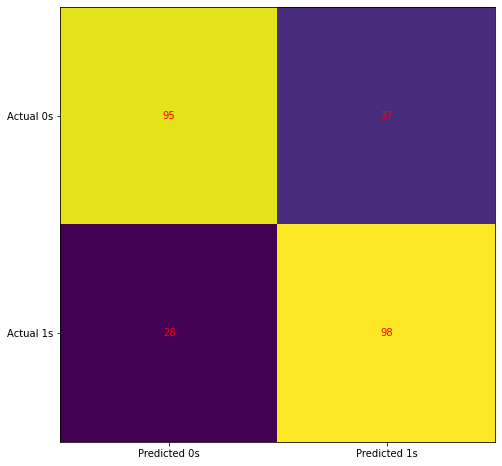

In [7]:
# model analysis
print(model.classes_)
print(f"Model accuracy on training data: {model.score(X_train, y_train)} ")
print(f"Model accuracy on test data: {model.score(X_test, y_test)} ")

print()
print(f"Classification report:\n {classification_report(y_test, model.predict(X_test))} ")
cm = confusion_matrix(y_test, model.predict(X_test))
print(f"Confusion matrix:\n {cm}")
plot_cm(cm)

In [8]:
# Create a model and train
model2 = LogisticRegression(solver='liblinear', C=0.005, random_state=0)
model2.fit(X_train, y_train)

LogisticRegression(C=0.005, random_state=0, solver='liblinear')

[0 1]
Model accuracy on training data: 1.0 
Model accuracy on test data: 0.751937984496124 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       132
           1       0.73      0.77      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[97 35]
 [29 97]]


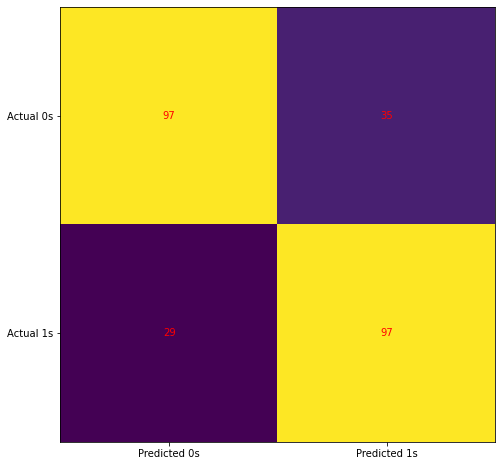

In [9]:
# model analysis
print(model2.classes_)
print(f"Model accuracy on training data: {model2.score(X_train, y_train)} ")
print(f"Model accuracy on test data: {model2.score(X_test, y_test)} ")

print()
print(f"Classification report:\n {classification_report(y_test, model2.predict(X_test))} ")
cm2 = confusion_matrix(y_test, model2.predict(X_test))
print(f"Confusion matrix:\n {cm2}")
plot_cm(cm2)